Data loaded: 364 training samples, 91 validation samples, 114 test samples
Number of features: 30
Starting parameter fine-tuning...


Testing parameters: 100%|██████████| 240/240 [1:09:40<00:00, 17.42s/it]



Parameter search complete!
Best parameters: Grid size=5.0, Sigma=1.0, Learning rate=0.7, Epochs=50.0
Best quantization error: 0.0000

Training SOM with best parameters...
Test set quantization error: 0.0501


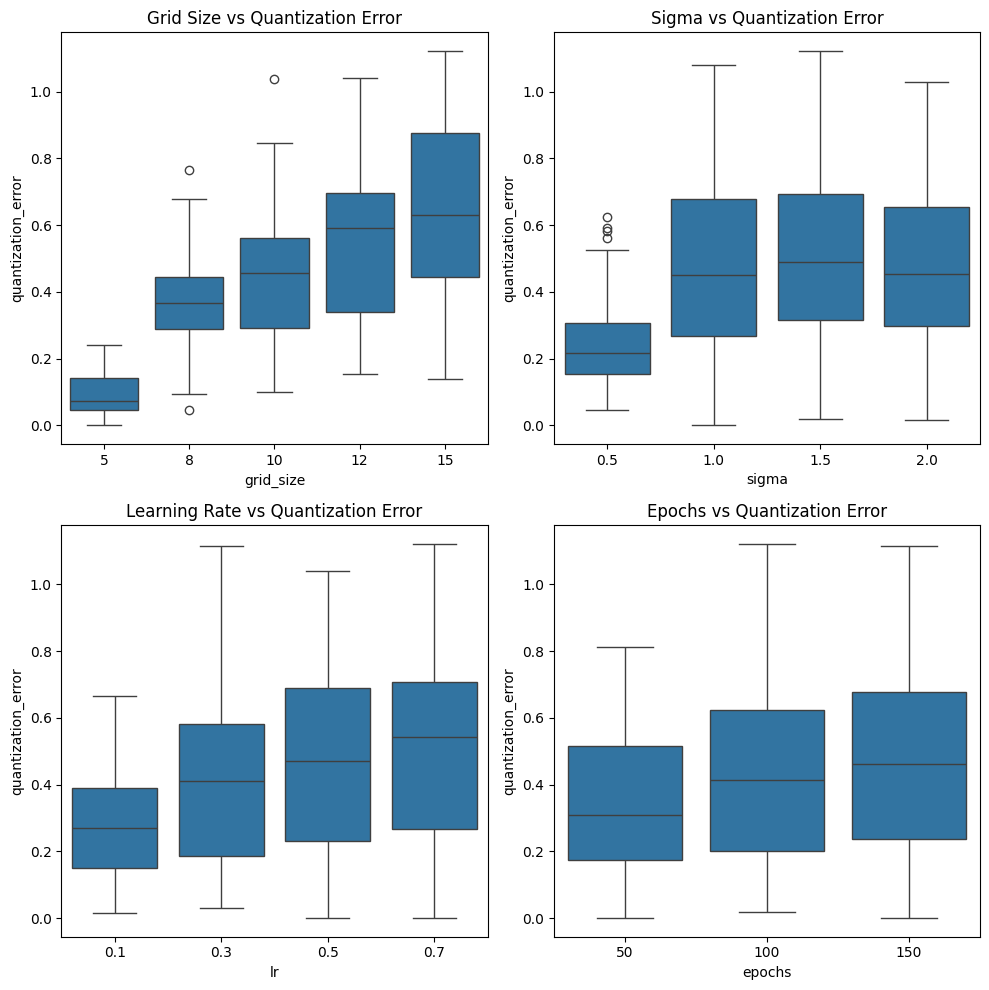


Visualizing SOM results...


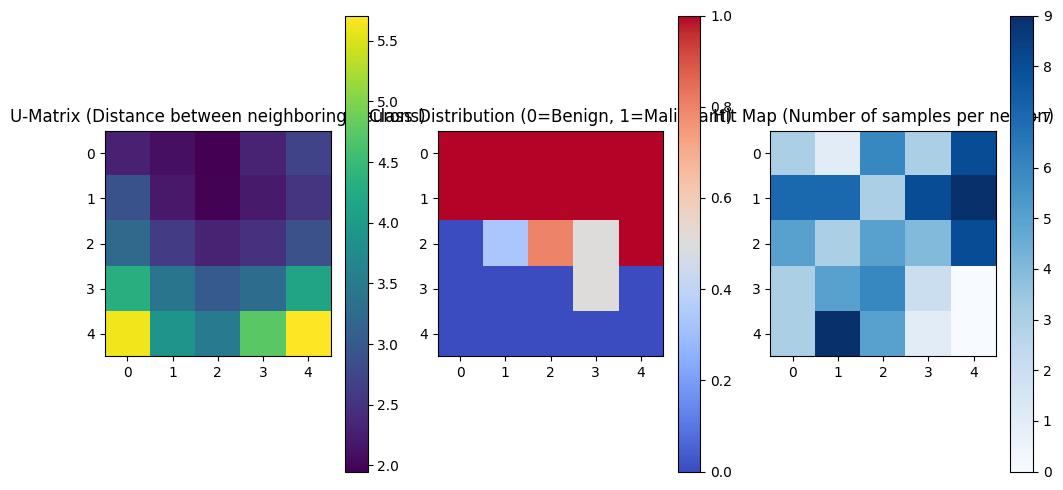

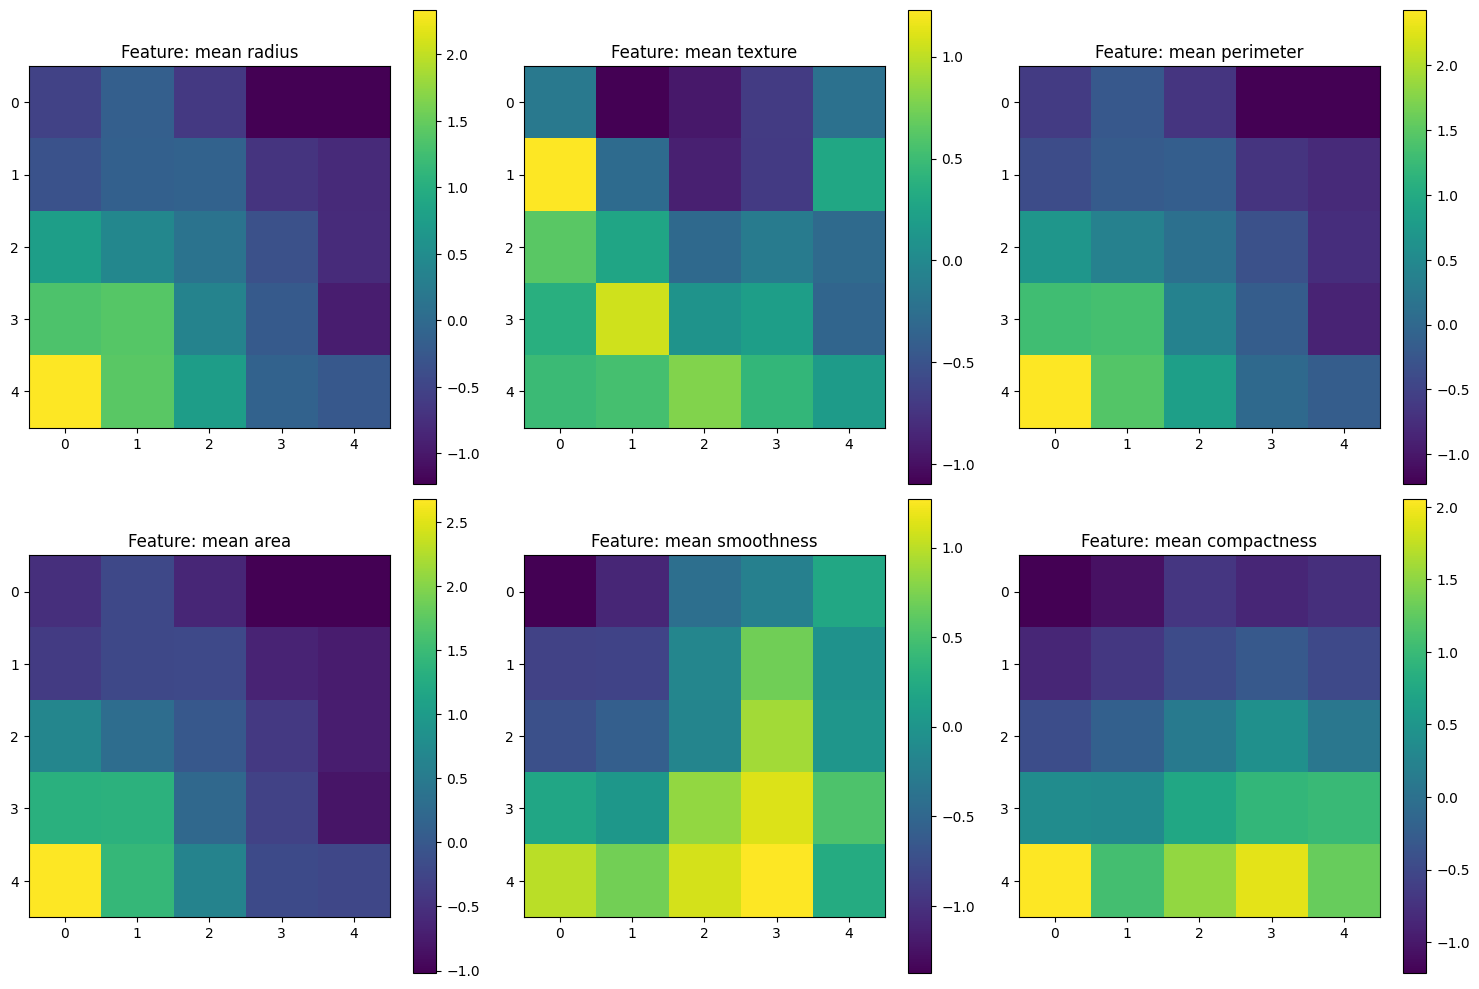

In [2]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

class StandardSOM:
    """
    Optimized Standard Self-Organizing Map (SOM) implementation
    """
    def __init__(self, grid_size, input_dim, sigma=1.0, lr=0.5):
        if isinstance(grid_size, int):
            grid_size = (grid_size, grid_size)
        self.grid = np.random.rand(grid_size[0], grid_size[1], input_dim)
        self.sigma = sigma
        self.lr = lr
        self.grid_size = grid_size
        self.input_dim = input_dim

        # Pre-compute grid coordinates for faster BMU calculation
        self.grid_coords = np.array([(i, j) for i in range(grid_size[0]) for j in range(grid_size[1])])

    def find_bmu(self, x):
        """Optimized BMU finding"""
        # Reshape grid for vectorized distance calculation
        flat_grid = self.grid.reshape(-1, self.input_dim)
        # Calculate distances to all neurons at once
        distances = np.linalg.norm(flat_grid - x, axis=1)
        # Find index of minimum distance
        min_idx = np.argmin(distances)
        # Convert to 2D coordinates
        return (min_idx // self.grid_size[1], min_idx % self.grid_size[1])

    def train(self, data, epochs, batch_size=32):
        """
        Train the SOM with batch updates for speed
        """
        # Pre-compute a neighborhood cache for common distances
        max_dist = np.sqrt(self.grid_size[0]**2 + self.grid_size[1]**2)
        dist_cache = np.linspace(0, max_dist, 1000)

        # Only use a sample of data for faster training
        if len(data) > 1000:
            np.random.shuffle(data)
            data_sample = data[:1000]
        else:
            data_sample = data

        for epoch in range(epochs):
            # Decay parameters
            current_sigma = self.sigma * (1 - epoch/epochs)
            current_lr = self.lr * (1 - epoch/epochs)

            # Process data in batches
            np.random.shuffle(data_sample)
            for i in range(0, len(data_sample), batch_size):
                batch = data_sample[i:i+batch_size]

                # Find BMUs for the entire batch
                bmus = np.array([self.find_bmu(x) for x in batch])

                # Update each neuron once based on all BMUs
                for i in range(self.grid_size[0]):
                    for j in range(self.grid_size[1]):
                        neuron_pos = np.array([i, j])

                        # Calculate distances to all BMUs at once
                        distances = np.sqrt(np.sum((bmus - neuron_pos)**2, axis=1))

                        # Calculate influence for each distance
                        influences = np.exp(-distances**2 / (2 * current_sigma**2))

                        # Calculate weight update from all batch items
                        update = np.zeros(self.input_dim)
                        for k, x in enumerate(batch):
                            update += influences[k] * (x - self.grid[i, j])

                        # Apply the update
                        self.grid[i, j] += current_lr * update / len(batch)

    def quantization_error(self, data, sample_size=500):

        # Map data points to their BMU weight vectors
        bmu_weights = np.array([self.grid[self.find_bmu(x)] for x in data])

        # Compute pairwise distances using a more efficient approach
        distances = pairwise_distances(bmu_weights)

        # For each point, find its closest neighbor (excluding itself)
        np.fill_diagonal(distances, np.inf)
        min_distances = np.min(distances, axis=1)

        # Return the average minimum distance
        return np.mean(min_distances)


def fine_tune_som_parameters(X_train, X_val):
    """
    Find the best parameters for SOM using a reduced grid search
    """
    # Define a smaller parameter grid
    param_grid = {
        'grid_size': [5, 8, 10, 12, 15],
        'sigma': [0.5, 1.0, 1.5, 2.0],
        'lr': [0.1, 0.3, 0.5, 0.7],
        'epochs': [50, 100, 150]
    }

    # Create parameter combinations
    param_combinations = []
    for grid_size in param_grid['grid_size']:
        for sigma in param_grid['sigma']:
            for lr in param_grid['lr']:
                for epochs in param_grid['epochs']:
                    param_combinations.append((grid_size, sigma, lr, epochs))

    # Store results
    results = []

    # Run grid search
    for grid_size, sigma, lr, epochs in tqdm(param_combinations, desc="Testing parameters"):
        # Initialize and train SOM
        som = StandardSOM(
            grid_size=grid_size,
            input_dim=X_train.shape[1],
            sigma=sigma,
            lr=lr
        )
        som.train(X_train, epochs=epochs)

        # Evaluate on validation set
        error = som.quantization_error(X_val)

        # Store results
        results.append({
            'grid_size': grid_size,
            'sigma': sigma,
            'lr': lr,
            'epochs': epochs,
            'quantization_error': error
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find best parameters
    best_idx = results_df['quantization_error'].idxmin()
    best_params = results_df.iloc[best_idx].to_dict()

    return best_params, results_df


def load_and_preprocess_data():
    """Load and preprocess the breast cancer dataset"""
    # Load data
    data = load_breast_cancer()
    X, y = data.data, data.target

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data - use smaller validation set
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Use a smaller validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42  # Reduced from 0.25 to 0.2
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, data.feature_names


# The rest of the code remains the same
def visualize_som_results(som, X, y, feature_names):


    # 1. U-Matrix (Distance heatmap)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    u_matrix = np.zeros(som.grid_size)
    for i in range(som.grid_size[0]):
        for j in range(som.grid_size[1]):
            # Calculate average distance to neighbors
            neighbors = []
            if i > 0:
                neighbors.append(som.grid[i-1, j])
            if i < som.grid_size[0] - 1:
                neighbors.append(som.grid[i+1, j])
            if j > 0:
                neighbors.append(som.grid[i, j-1])
            if j < som.grid_size[1] - 1:
                neighbors.append(som.grid[i, j+1])

            distances = [np.linalg.norm(som.grid[i, j] - neighbor) for neighbor in neighbors]
            u_matrix[i, j] = np.mean(distances)

    plt.imshow(u_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('U-Matrix (Distance between neighboring neurons)')

    # 2. Class distribution heatmap
    plt.subplot(1, 3, 2)
    class_map = np.zeros(som.grid_size)
    counts = np.zeros(som.grid_size)

    for i, x in enumerate(X):
        bmu = som.find_bmu(x)
        class_map[bmu] += y[i]  # 0 for benign, 1 for malignant
        counts[bmu] += 1

    # Prevent division by zero
    counts[counts == 0] = 1
    class_map = class_map / counts

    plt.imshow(class_map, cmap='coolwarm', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Class Distribution (0=Benign, 1=Malignant)')

    # 3. Hit map
    plt.subplot(1, 3, 3)
    hit_map = np.zeros(som.grid_size)

    for x in X:
        bmu = som.find_bmu(x)
        hit_map[bmu] += 1

    plt.imshow(hit_map, cmap='Blues')
    plt.colorbar()
    plt.title('Hit Map (Number of samples per neuron)')

    plt.tight_layout()
    plt.show()

    # 4. Feature heatmaps for selected features
    n_features = min(6, len(feature_names))
    plt.figure(figsize=(15, 10))

    for i in range(n_features):
        plt.subplot(2, 3, i+1)
        feature_map = np.zeros(som.grid_size)

        for row in range(som.grid_size[0]):
            for col in range(som.grid_size[1]):
                feature_map[row, col] = som.grid[row, col, i]

        plt.imshow(feature_map, cmap='viridis')
        plt.colorbar()
        plt.title(f'Feature: {feature_names[i]}')

    plt.tight_layout()
    plt.show()


def main():
    # Load and preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test, feature_names = load_and_preprocess_data()

    print(f"Data loaded: {X_train.shape[0]} training samples, {X_val.shape[0]} validation samples, {X_test.shape[0]} test samples")
    print(f"Number of features: {X_train.shape[1]}")

    # Fine-tune parameters
    print("Starting parameter fine-tuning...")
    best_params, results_df = fine_tune_som_parameters(X_train, X_val)

    print("\nParameter search complete!")
    print(f"Best parameters: Grid size={best_params['grid_size']}, Sigma={best_params['sigma']}, "
          f"Learning rate={best_params['lr']}, Epochs={best_params['epochs']}")
    print(f"Best quantization error: {best_params['quantization_error']:.4f}")

    # Train SOM with best parameters
    print("\nTraining SOM with best parameters...")
    best_som = StandardSOM(
        grid_size=int(best_params['grid_size']),
        input_dim=X_train.shape[1],
        sigma=best_params['sigma'],
        lr=best_params['lr']
    )
    best_som.train(X_train, epochs=int(best_params['epochs']))

    # Evaluate on test set
    test_error = best_som.quantization_error(X_test)
    print(f"Test set quantization error: {test_error:.4f}")

    # Visualize parameter search results
    plt.figure(figsize=(10, 10))

    # Grid size vs error
    plt.subplot(2, 2, 1)
    sns.boxplot(x='grid_size', y='quantization_error', data=results_df)
    plt.title('Grid Size vs Quantization Error')

    # Sigma vs error
    plt.subplot(2, 2, 2)
    sns.boxplot(x='sigma', y='quantization_error', data=results_df)
    plt.title('Sigma vs Quantization Error')

    # Learning rate vs error
    plt.subplot(2, 2, 3)
    sns.boxplot(x='lr', y='quantization_error', data=results_df)
    plt.title('Learning Rate vs Quantization Error')

    # Epochs vs error
    plt.subplot(2, 2, 4)
    sns.boxplot(x='epochs', y='quantization_error', data=results_df)
    plt.title('Epochs vs Quantization Error')

    plt.tight_layout()
    plt.show()

    # Visualize SOM results
    print("\nVisualizing SOM results...")
    visualize_som_results(best_som, X_test, y_test, feature_names)


if __name__ == "__main__":
    main()